In [1]:
import mxnet as mx
from mxnet.gluon.model_zoo import vision
from gluoncv import model_zoo, data, utils
import os
import numpy as np
import glob
import pandas as pd
#from scipy.spatial.distance import cosine
from IPython.display import Image 

# set the context on CPU, switch to GPU if there is one available
ctx = mx.cpu()

import glob2
from tqdm import tqdm
import matplotlib.pyplot as plt

def yolo_extraction(fnx):
    x, img = data.transforms.presets.yolo.load_test(fn, short=512)
    class_IDs, scores, bounding_boxs = net(x)
    for index, bbox in enumerate(bounding_boxs[0]):
        class_ID = int(class_IDs[0][index].asnumpy()[0])
        class_name = net.classes[class_ID]
        class_score = scores[0][index].asnumpy()
        if (class_name == 'person') & (class_score > 0.9):
            #print('index: ', index)
            #print('class_ID: ', class_ID)
            #print('class_name: ', class_name)
            #print('class_score: ',class_score)
            #print('bbox: ', bbox.asnumpy())
            xmin, ymin, xmax, ymax = [int(x) for x in bbox.asnumpy()]
            xmin = max(0, xmin)
            xmax = min(x.shape[3], xmax)
            ymin = max(0, ymin)
            ymax = min(x.shape[2], ymax)
            im_fname_save = fnx.replace('.jpg','_humanCrop.jpg')
            plt.imsave(im_fname_save, img[ymin:ymax,xmin:xmax,:])
            return 
def cropNormFit(fnx):
    '''
    accepts an mx decoded a filename of an image
    returns an mxnet array ready for transformation image
    '''
        
    image = mx.image.imdecode(open(fn, 'rb').read()).astype(np.float32)
    resized = mx.image.resize_short(image, 224) #minimum 224x224 images
    cropped, crop_info = mx.image.center_crop(resized, (224, 224))
    normalized = mx.image.color_normalize(cropped/255,
                                          mean=mx.nd.array([0.485, 0.456, 0.406]),
                                          std=mx.nd.array([0.229, 0.224, 0.225])) 
    # the network expect batches of the form (N,3,224,224)
    flipped_axis = normalized.transpose((2,0,1))  # Flipping from (224, 224, 3) to (3, 224, 224)
    batchified = flipped_axis.expand_dims(axis=0) # change the shape from (3, 224, 224) to (1, 3, 224, 224)
    return batchified

def vectorize(batchified, preloaded_model):
    '''
    accepts a preprocessed vector
    returns a numpy transformation
    '''
    return preloaded_model.features(batchified)[0].asnumpy()

def cosineSimilarity(u, v):
    similarity = np.dot(u,v) / (np.linalg.norm(u) * np.linalg.norm(v))
    return similarity
    
    

In [2]:
%time densenet = vision.densenet201(pretrained=True)
type(densenet)
%time net = model_zoo.get_model('yolo3_darknet53_voc', pretrained=True)

CPU times: user 570 ms, sys: 240 ms, total: 810 ms
Wall time: 686 ms
CPU times: user 497 ms, sys: 292 ms, total: 788 ms
Wall time: 734 ms


/Users/officialbiznas/Documents/GitHub/ImageSimilarity/data/raw/human/lizzo.jpeg
[1.08518114e-04 1.06997369e-03 6.87173626e-04 ... 8.31125855e-01
 1.49336445e+00 6.33963537e+00]


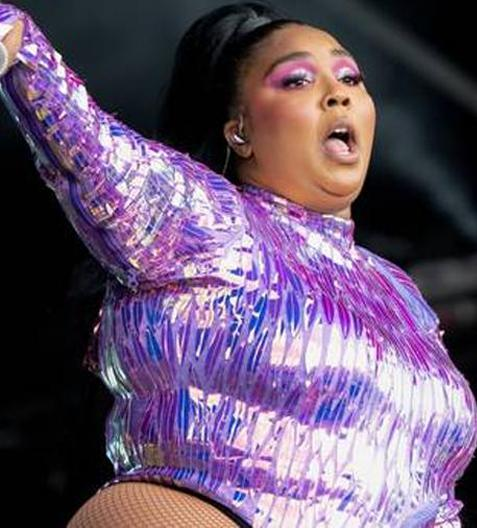

In [5]:
fn = os.path.join(os.path.dirname(os.getcwd()), 'data', 'raw','human/rock.jpg')
fn = glob2.glob(os.path.join(os.path.dirname(os.getcwd()), 'data', 'raw','human/lizzo.jpeg'))[0]
#0 or work well
print(fn)
fn_yolo = yolo_extraction(fn)
image_array = cropNormFit(fn_yolo)
image_vect = vectorize(image_array, preloaded_model=densenet)
print(image_vect)
Image(filename=fn)

Rows Comparing against:  13732


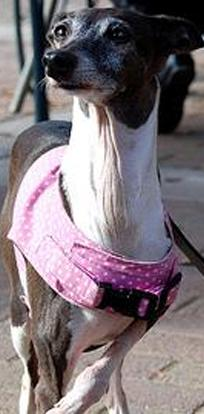

In [6]:
fn_df_save = os.path.join(os.path.dirname(os.getcwd()), 'data', 'processed','0.0.6-whs-dogVectors.h5')
df_model = pd.read_hdf(fn_df_save, key='df')
print('Rows Comparing against: ', df_model.count()[0])
#ref_vsc = densenet.features(batchified)[0].asnumpy()

df_model['cosim'] = df_model['vector'].apply(lambda x: cosineSimilarity(x, image_vect))
df_model = df_model.sort_values('cosim', ascending=False).reset_index(drop=True)

#Image(filename=)
df_model.head()
#for x in range(3):
Image(filename=df_model.fn.loc[0])


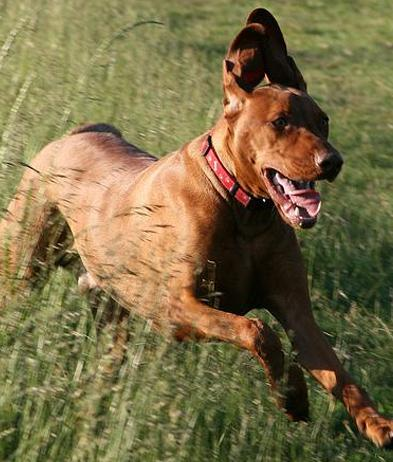

In [7]:
Image(filename=df_model.fn.loc[1])

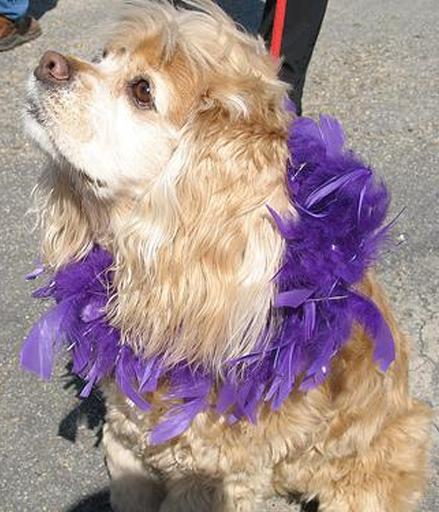

In [8]:
Image(filename=df_model.fn.loc[2])

In [55]:
print('Prepping INput Image')
image = mx.image.imdecode(open(fn, 'rb').read()).astype(np.float32)
resized = mx.image.resize_short(image, 224) #minimum 224x224 images
cropped, crop_info = mx.image.center_crop(resized, (224, 224))
normalized = mx.image.color_normalize(cropped/255,
                                      mean=mx.nd.array([0.485, 0.456, 0.406]),
                                      std=mx.nd.array([0.229, 0.224, 0.225])) 
# the network expect batches of the form (N,3,224,224)
flipped_axis = normalized.transpose((2,0,1))  # Flipping from (224, 224, 3) to (3, 224, 224)
batchified = flipped_axis.expand_dims(axis=0) # change the shape from (3, 224, 224) to (1, 3, 224, 224)
ref_vsc = densenet.features(batchified)[0].asnumpy()

Prepping INput Image


In [34]:
labels = [df['fn'].loc[index].split('/')[-1] for index in range(df.count()[0])]
df_cross = pd.DataFrame(columns=labels, index=labels)



for index in tqdm(range(df_model.count()[0])):
    cos_sim = cosineSimilarity(u = df_model['vector'].loc[index],
                                v = test_vec)
    df_model['ref_cosim'].loc[index] = cos_sim
    
df_model = df_model.sort_values('ref_cosim', ascending=False).reset_index(drop=True)
print(df_model['fn'].loc[0])
print(df_model['ref_cosim'].loc[0])
Image(filename=df_model['fn'].loc[0])

  0%|          | 0/18983 [00:00<?, ?it/s]


ValueError: shapes (3,) and (1920,) not aligned: 3 (dim 0) != 1920 (dim 0)

/Users/officialbiznas/Documents/GitHub/ImageSimilarity/data/raw/human/IMG_0220.jpg
0.99999994


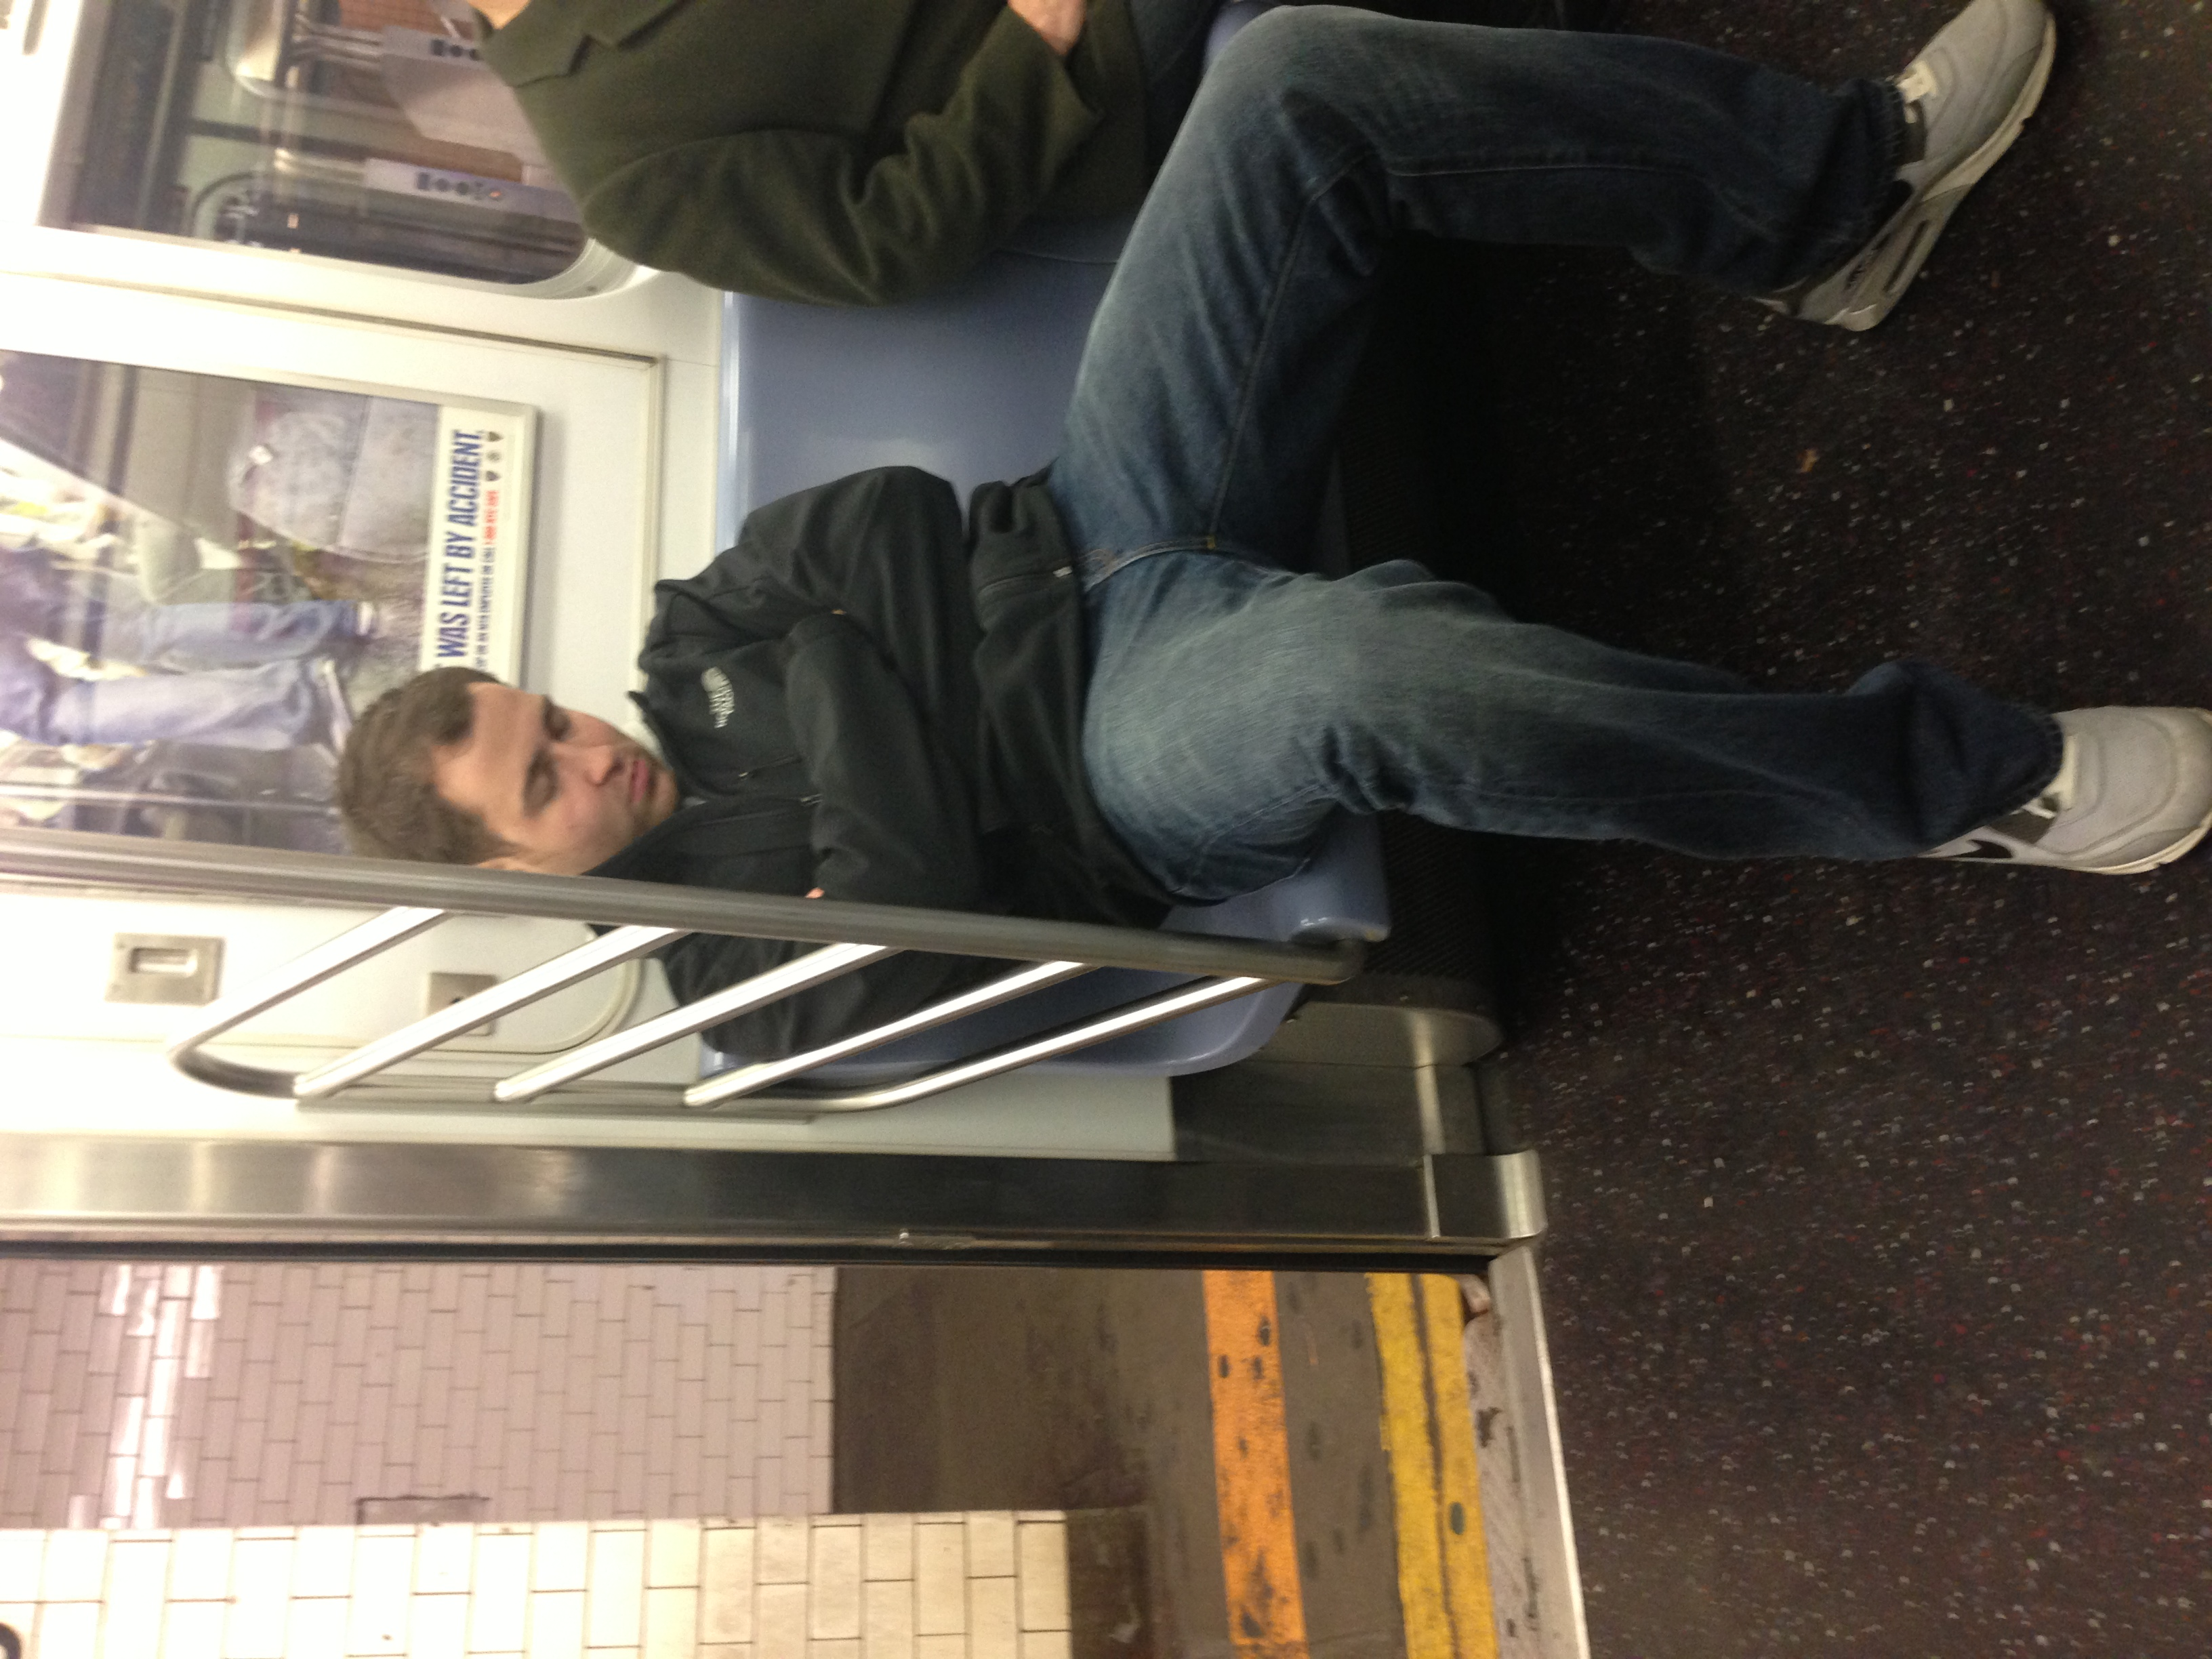

In [23]:
df_model = df_model.sort_values('ref_cosim', ascending=False).reset_index(drop=True)

print(df_model['fn'].loc[0])
print(df_model['ref_cosim'].loc[0])
Image(filename=df_model['fn'].loc[0])

/Users/officialbiznas/Documents/GitHub/ImageSimilarity/data/raw/boxer/n02108089_926.jpg
0.5911584


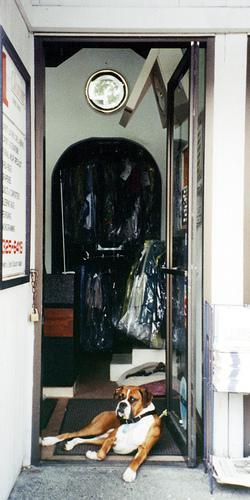

In [24]:
print(df_model['fn'].loc[2])
print(df_model['ref_cosim'].loc[2])
Image(filename=df_model['fn'].loc[2])

/Users/officialbiznas/Documents/GitHub/ImageSimilarity/data/raw/corgi-cardigan/n02113186_10535.jpg
0.589923


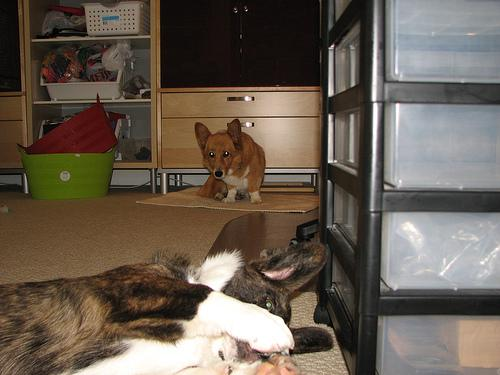

In [21]:
print(df_model['fn'].loc[3])
print(df_model['ref_cosim'].loc[3])
Image(filename=df_model['fn'].loc[3])